In [ ]:
!pip install flask
import flask
from IPython import get_ipython

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!touch app.py
with open('/content/app.py', 'w') as writefile:
    writefile.write("from flask import Flask, jsonify\nimport base64\napp = Flask(__name__)\n\n\n@app.route('/')\ndef index():\n\tdata = open(\"/content/data.txt\", \"r+\")\n\tdata = str(data.read())\n\tjson = data.split(',')\n\twith open(\"/content/1.png\", \"rb\") as img_file:\n\t\tb64_string = base64.b64encode(img_file.read())\n\timage = b64_string.decode('utf-8')\n\tres = jsonify(cbow=json[0], lstm=json[1], cnn_lstm=json[2], image=image)\n\tres.headers.add(\"Access-Control-Allow-Origin\", \"*\")\n\treturn res\n\nif __name__ == '__main__':\n\tapp.run()")
!touch data.txt
get_ipython().system_raw('python app.py &')
get_ipython().system_raw('./ngrok http 5000 &')

--2021-04-24 21:16:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.209.238.187, 50.19.119.19, 3.223.68.239, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.209.238.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13828408 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.9MB/s    in 0.7s    

2021-04-24 21:16:26 (17.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13828408/13828408]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


0        False
1        False
2        False
3         True
4         True
         ...  
71039    False
71040    False
71041    False
71042    False
71043    False
Name: target, Length: 71044, dtype: bool


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 26057 unique tokens.
average length: 39.4
max length: 1034


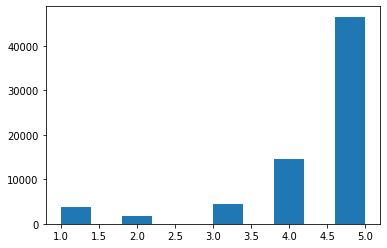

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

from keras import backend as K
import matplotlib.pyplot as plt

import io
import requests

url="https://ml-nci.s3.amazonaws.com/GrammarandProductReviews.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

plt.hist(df['reviews.rating'])

df['target'] = df['reviews.rating'] < 4

print(df['target'])

train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'], df['target'], test_size=0.2)

train_text.shape

MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequences[0]

type(tokenizer.word_index), len(tokenizer.word_index)

index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

" ".join([index_to_word[i] for i in sequences[0]])

seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

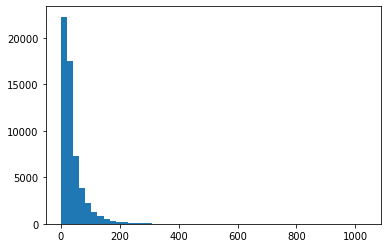

In [ ]:
plt.hist(seq_lens, bins=50);

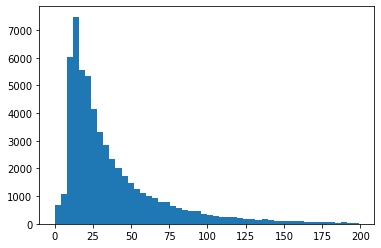

In [ ]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [ ]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (56835, 150)
Shape of data test tensor: (14209, 150)
Shape of label tensor: (56835, 2)


In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128)
output_test = model.predict(x_test)
print("auc:", roc_auc_score(y_test,output_test[:,1]))
cbow = roc_auc_score(y_test,output_test[:,1])

Epoch 1/10
400/400 [==============================] - 9s 20ms/step - loss: 0.4758 - acc: 0.8421 - val_loss: 0.3615 - val_acc: 0.8621
Epoch 2/10
400/400 [==============================] - 7s 17ms/step - loss: 0.3396 - acc: 0.8676 - val_loss: 0.3078 - val_acc: 0.8761
Epoch 3/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2796 - acc: 0.8862 - val_loss: 0.2716 - val_acc: 0.8900
Epoch 4/10
400/400 [==============================] - 7s 17ms/step - loss: 0.2433 - acc: 0.9014 - val_loss: 0.2545 - val_acc: 0.9008
Epoch 5/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2215 - acc: 0.9107 - val_loss: 0.2456 - val_acc: 0.9025
Epoch 6/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2094 - acc: 0.9152 - val_loss: 0.2392 - val_acc: 0.9064
Epoch 7/10
400/400 [==============================] - 7s 17ms/step - loss: 0.1976 - acc: 0.9221 - val_loss: 0.2359 - val_acc: 0.9083
Epoch 8/10
400/400 [==============================] - 7s 17ms/step - 

In [ ]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(2, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.fit(x_train, y_train, validation_split=0.1,
          epochs=2, batch_size=128)
output_test = model.predict(x_test)
print("auc:", roc_auc_score(y_test,output_test[:,1]))
lstm = roc_auc_score(y_test,output_test[:,1])

Epoch 1/2
400/400 [==============================] - 296s 735ms/step - loss: 0.2197 - acc: 0.9188 - val_loss: 0.2286 - val_acc: 0.9136
Epoch 2/2
400/400 [==============================] - 296s 739ms/step - loss: 0.1623 - acc: 0.9396 - val_loss: 0.2558 - val_acc: 0.8997
auc: 0.9147704639146433


In [ ]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.fit(x_train, y_train, validation_split=0.1,
          epochs=5, batch_size=128)
output_test = model.predict(x_test)
print("auc:", roc_auc_score(y_test,output_test[:,1]))
cnn_lstm = roc_auc_score(y_test,output_test[:,1])

Epoch 1/5
400/400 [==============================] - 38s 90ms/step - loss: 0.2215 - acc: 0.9153 - val_loss: 0.2354 - val_acc: 0.9110
Epoch 2/5
400/400 [==============================] - 35s 88ms/step - loss: 0.1644 - acc: 0.9380 - val_loss: 0.2381 - val_acc: 0.9145
Epoch 3/5
400/400 [==============================] - 35s 88ms/step - loss: 0.1478 - acc: 0.9455 - val_loss: 0.2437 - val_acc: 0.9119
Epoch 4/5
400/400 [==============================] - 36s 89ms/step - loss: 0.1390 - acc: 0.9496 - val_loss: 0.2592 - val_acc: 0.9145
Epoch 5/5
400/400 [==============================] - 36s 89ms/step - loss: 0.1253 - acc: 0.9559 - val_loss: 0.2723 - val_acc: 0.9106
auc: 0.8958309193030759


(3000, 2)
(3000,)


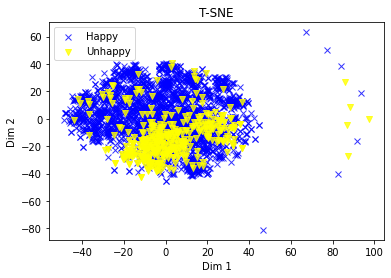

In [ ]:
from keras import backend as K
get_emb_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].input])
embedding_output = get_emb_layer_output([x_test[:3000]])[0]
emb_shape = embedding_output.shape
to_plot_embedding = embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y = y_test[:3000]
sentence_emb_tsne = TSNE(perplexity=30).fit_transform(to_plot_embedding)
print(sentence_emb_tsne.shape)
print(y.shape)
plt.figure()
plt.scatter(sentence_emb_tsne[np.where(y == 0), 0],
                   sentence_emb_tsne[np.where(y == 0), 1],
                   marker='x', color='blue',
                   linewidth='1', alpha=0.8, label='Happy')
plt.scatter(sentence_emb_tsne[np.where(y == 1), 0],
                   sentence_emb_tsne[np.where(y == 1), 1],
                   marker='v', color='yellow',
                   linewidth='1', alpha=0.8, label='Unhappy')

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='best')
plt.savefig('1.png')
plt.show()

In [ ]:
cbowstr = str(cbow)
lstmstr = str(lstm)
cnn_lstmstr = str(cnn_lstm)
s = cbowstr+","+lstmstr+","+cnn_lstmstr
with open('/content/data.txt', 'w') as writefile:
    writefile.write(s)

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d6aa18d6b372.ngrok.io


In [ ]:
file1 = open("/content/data.txt","r+") 
print("Output of Read function is ")
print(file1.read())

Output of Read function is 
0.9120493319487815,0.9147704639146433,0.8958309193030759
